<a href="https://colab.research.google.com/github/xavdx/Nutrition-Paradox/blob/main/Nutrition_Paradox_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install requests pycountry

In [ ]:
import pandas as pd
import requests
import pycountry
import json

In [ ]:
#Obesity
adult_obesity_url= "https://ghoapi.azureedge.net/api/NCD_BMI_30C"
child_obesity_url= "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C"
#Malnutrition
adult_malnutrition_url= "https://ghoapi.azureedge.net/api/NCD_BMI_18C"
child_malnutrition_url= "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"

In [ ]:
def fetch_who_data(api_url):
    response= requests.get(api_url)
    if response.status_code== 200:
        data= response.json()['value']
        df= pd.json_normalize(data)
        return df
    else:
        print("Failed to fetch data:", response.status_code)
        return pd.DataFrame()

In [ ]:
df_adult_obesity= fetch_who_data(adult_obesity_url)
df_child_obesity= fetch_who_data(child_obesity_url)

df_adult_malnutrition= fetch_who_data(adult_malnutrition_url)
df_child_malnutrition= fetch_who_data(child_malnutrition_url)

In [ ]:
df_adult_obesity['age_group'] = 'Adult'
df_child_obesity['age_group'] = 'Child'

df_adult_malnutrition['age_group'] = 'Adult'
df_child_malnutrition['age_group'] = 'Child'

In [ ]:
df_obesity = pd.concat([df_adult_obesity, df_child_obesity], ignore_index=True)
df_malnutrition = pd.concat([df_adult_malnutrition, df_child_malnutrition], ignore_index=True)

In [ ]:
df_obesity = df_obesity[df_obesity['TimeDim'].between(2012, 2022)]
df_malnutrition = df_malnutrition[df_malnutrition['TimeDim'].between(2012, 2022)]

In [ ]:
#Keeping only the required columns
keep_cols=['TimeDim', 'Dim1', 'NumericValue', 'Low', 'High', 'ParentLocation', 'SpatialDim', 'age_group']

df_obesity= df_obesity[keep_cols].copy()
df_malnutrition= df_malnutrition[keep_cols].copy()

#Rename columns
rename_cols={
    'TimeDim': 'Year',
    'Dim1': 'Gender',
    'NumericValue': 'Mean_Estimate',
    'Low': 'LowerBound',
    'High': 'UpperBound',
    'ParentLocation': 'Region',
    'SpatialDim': 'Country'
}
df_obesity.rename(columns=rename_cols, inplace=True)
df_malnutrition.rename(columns=rename_cols, inplace=True)

In [ ]:
def clean_gender(value):
    if 'male' in value.lower():
        return 'Male'
    elif 'female' in value.lower():
        return 'Female'
    else:
        return 'Both'

df_obesity['Gender']= df_obesity['Gender'].apply(clean_gender)
df_malnutrition['Gender']= df_malnutrition['Gender'].apply(clean_gender)

In [ ]:
import pycountry

def convert_country_code(code):
    try:
        country= pycountry.countries.get(alpha_3=code)
        return country.name if country else None
    except:
        return None

df_obesity['Country']= df_obesity['Country'].apply(convert_country_code)
df_malnutrition['Country']= df_malnutrition['Country'].apply(convert_country_code)

In [ ]:
special_cases={
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}

# Fill missing country names using special_cases dictionary
df_obesity['Country'].fillna(df_obesity['Country'].map(special_cases), inplace=True)
df_malnutrition['Country'].fillna(df_malnutrition['Country'].map(special_cases), inplace=True)

/tmp/ipython-input-13-2196034688.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_malnutrition['Country'].fillna(df_malnutrition['Country'].map(special_cases), inplace=True)


In [ ]:
df_obesity['CI_Width'] = df_obesity['UpperBound'] - df_obesity['LowerBound']
df_malnutrition['CI_Width'] = df_malnutrition['UpperBound'] - df_malnutrition['LowerBound']

# **Step 2:**
**Creating Obesity levels and Malnutrition levels for the respective tables**

In [ ]:
def categorize_obesity(value):
    if value>=30:
        return 'High'
    elif value>=25 and value<30:
        return 'Moderate'
    else:
        return 'Low'
df_obesity['Obesity_Level']= df_obesity['Mean_Estimate'].apply(categorize_obesity)

In [ ]:
def categorize_malnutrition(value):
    if value>=20:
        return 'High'
    elif value>=10 and value<20:
        return 'Moderate'
    else:
        return 'Low'

df_malnutrition['Malnutrition_Level']=df_malnutrition['Mean_Estimate'].apply(categorize_malnutrition)

In [ ]:
df_malnutrition.columns

Index(['Year', 'Gender', 'Mean_Estimate', 'LowerBound', 'UpperBound', 'Region',
       'Country', 'age_group', 'CI_Width', 'Malnutrition_Level'],
      dtype='object')

In [ ]:
df_obesity.columns

Index(['Year', 'Gender', 'Mean_Estimate', 'LowerBound', 'UpperBound', 'Region',
       'Country', 'age_group', 'CI_Width', 'Obesity_Level'],
      dtype='object')

In [ ]:
df_malnutrition

,Year,Gender,Mean_Estimate,LowerBound,UpperBound,Region,Country,age_group,CI_Width,Malnutrition_Level
1,2021,Both,5.795110,3.972036,8.077021,Africa,Gabon,Adult,4.104985,Low
5,2017,Both,3.090652,2.428230,3.842155,Western Pacific,Mongolia,Adult,1.413925,Low
6,2016,Both,8.371724,6.655668,10.253121,Africa,Sierra Leone,Adult,3.597453,Low
8,2021,Both,13.336353,12.242323,14.442866,None,NaN,Adult,2.200543,Moderate
10,2014,Both,2.208070,1.253843,3.516819,Eastern Mediterranean,Qatar,Adult,2.262976,Low
...,...,...,...,...,...,...,...,...,...,...
83147,2013,Both,4.140693,2.795499,5.714345,Americas,Haiti,Child,2.918846,Low
83149,2018,Both,7.574986,5.428173,10.218395,Europe,Tajikistan,Child,4.790222,Low
83150,2016,Both,1.703645,0.621721,3.507061,Western Pacific,Papua New Guinea,Child,2.885340,Low
83156,2020,Both,0.734066,0.064152,2.810176,Western Pacific,Samoa,Child,2.746023,Low


# **Step 3:**
**A: Quick Data Overview**

In [ ]:
print("Obesity Dataset")
print(df_obesity.info())
print(df_obesity.describe())
print(df_obesity['Region'].value_counts())

print("\n\nMalnutrition Dataset")
print(df_malnutrition.info())
print(df_malnutrition.describe())
print(df_malnutrition['Region'].value_counts())

Obesity Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 27720 entries, 2 to 83154
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           27720 non-null  int64  
 1   Gender         27720 non-null  object 
 2   Mean_Estimate  27720 non-null  float64
 3   LowerBound     27720 non-null  float64
 4   UpperBound     27720 non-null  float64
 5   Region         26268 non-null  object 
 6   Country        26268 non-null  object 
 7   age_group      27720 non-null  object 
 8   CI_Width       27720 non-null  float64
 9   Obesity_Level  27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.3+ MB
None
               Year  Mean_Estimate    LowerBound    UpperBound      CI_Width
count  27720.000000   27720.000000  27720.000000  27720.000000  27720.000000
mean    2017.000000      12.761040      9.393155     17.068488      7.675334
std        3.162335      10.858925      9.893854     1

**B: Obesity Trend Over Years (Global Avg)**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


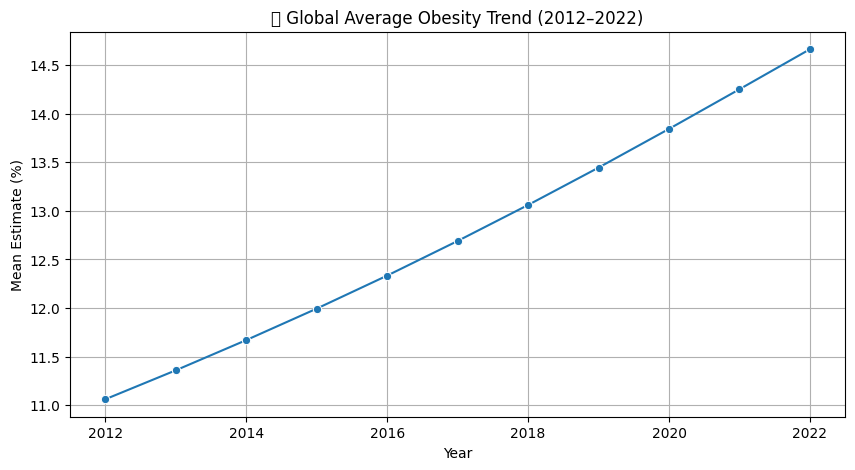

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
global_obesity = df_obesity.groupby('Year')['Mean_Estimate'].mean().reset_index()
sns.lineplot(data=global_obesity, x='Year', y='Mean_Estimate', marker='o')
plt.title("🌍 Global Average Obesity Trend (2012–2022)")
plt.ylabel("Mean Estimate (%)")
plt.grid()
plt.show()

C: Malnutrition Trend Over Years (Global Avg)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


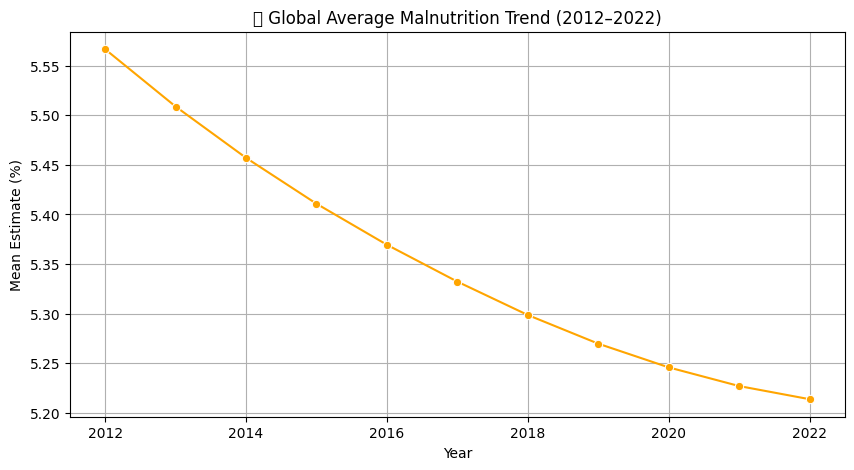

In [ ]:
plt.figure(figsize=(10, 5))
global_malnutrition = df_malnutrition.groupby('Year')['Mean_Estimate'].mean().reset_index()
sns.lineplot(data=global_malnutrition, x='Year', y='Mean_Estimate', marker='o', color='orange')
plt.title("🌍 Global Average Malnutrition Trend (2012–2022)")
plt.ylabel("Mean Estimate (%)")
plt.grid()
plt.show()

**D: Gender-Based Average Comparison (Obesity vs Malnutrition)**

/tmp/ipython-input-23-1594804512.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mal_gender_avg, x='Gender', y='Mean_Estimate', ax=ax[1], palette='autumn')


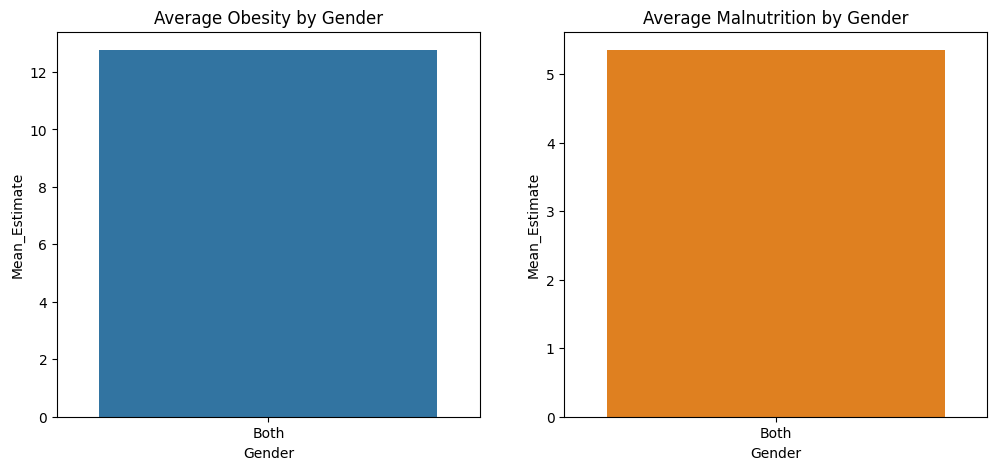

In [ ]:
ob_gender_avg = df_obesity.groupby('Gender')['Mean_Estimate'].mean().reset_index()
mal_gender_avg = df_malnutrition.groupby('Gender')['Mean_Estimate'].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=ob_gender_avg, x='Gender', y='Mean_Estimate', ax=ax[0])
ax[0].set_title("Average Obesity by Gender")

sns.barplot(data=mal_gender_avg, x='Gender', y='Mean_Estimate', ax=ax[1], palette='autumn')
ax[1].set_title("Average Malnutrition by Gender")

plt.show()

**E: Regional Variability– Boxplot by Region (Obesity)**

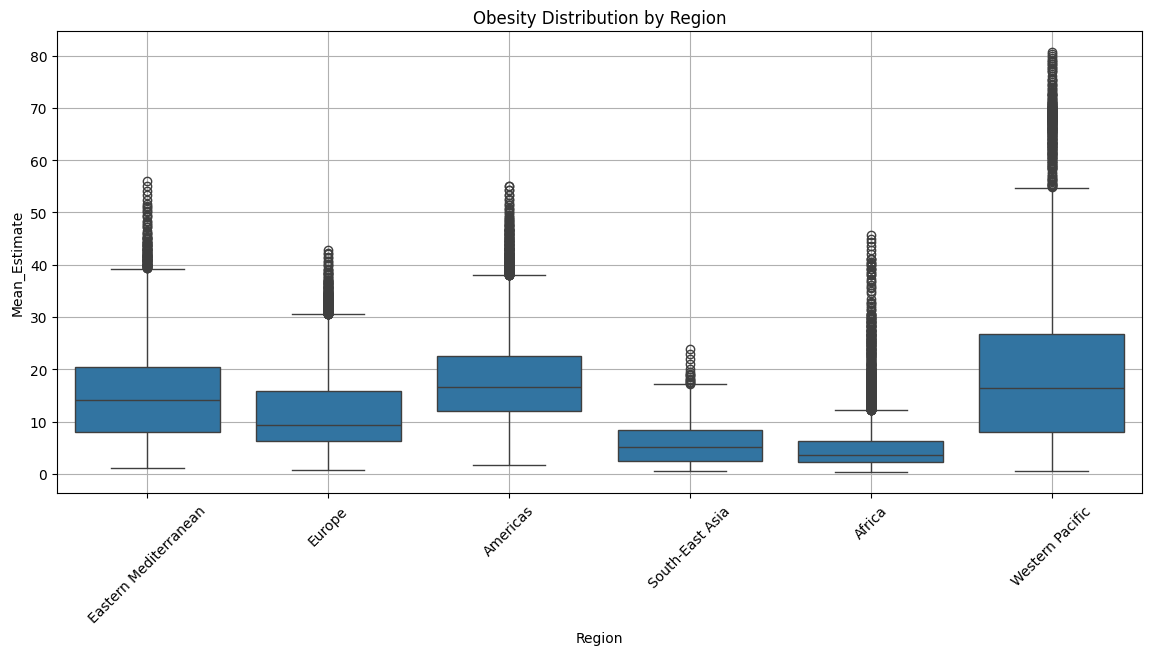

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_obesity, x='Region', y='Mean_Estimate')
plt.title("Obesity Distribution by Region")
plt.xticks(rotation=45)
plt.grid()
plt.show()

**F: Age Group Comparison– Obesity & Malnutrition**

/tmp/ipython-input-25-122641509.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_malnutrition, x='age_group', y='Mean_Estimate', ax=ax[1], palette='coolwarm')


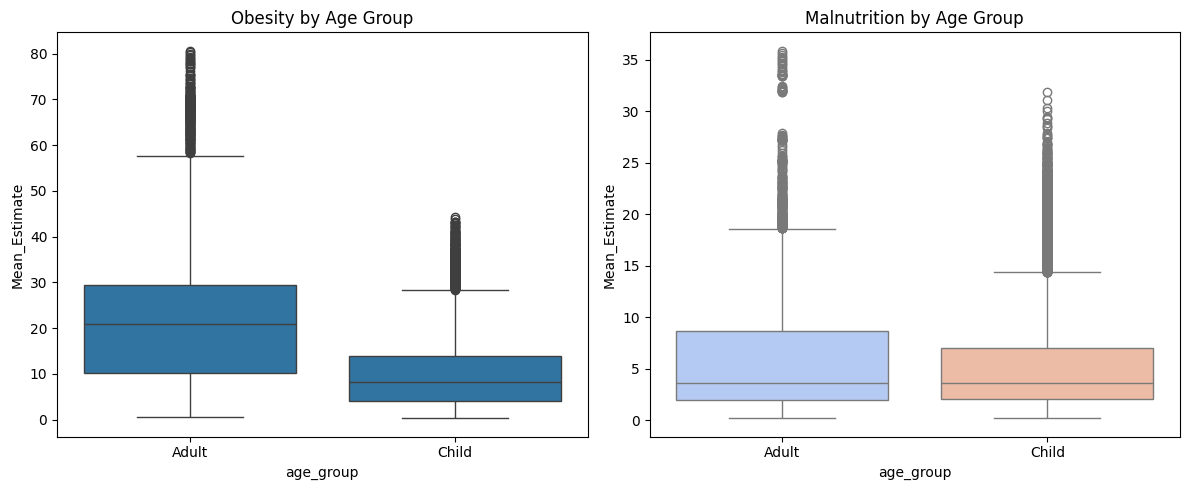

In [ ]:
fig,ax= plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df_obesity, x='age_group', y='Mean_Estimate', ax=ax[0])
ax[0].set_title("Obesity by Age Group")

sns.boxplot(data=df_malnutrition, x='age_group', y='Mean_Estimate', ax=ax[1], palette='coolwarm')
ax[1].set_title("Malnutrition by Age Group")

plt.tight_layout()
plt.show()

**G: Heatmap of CI_Width by Region & Year**

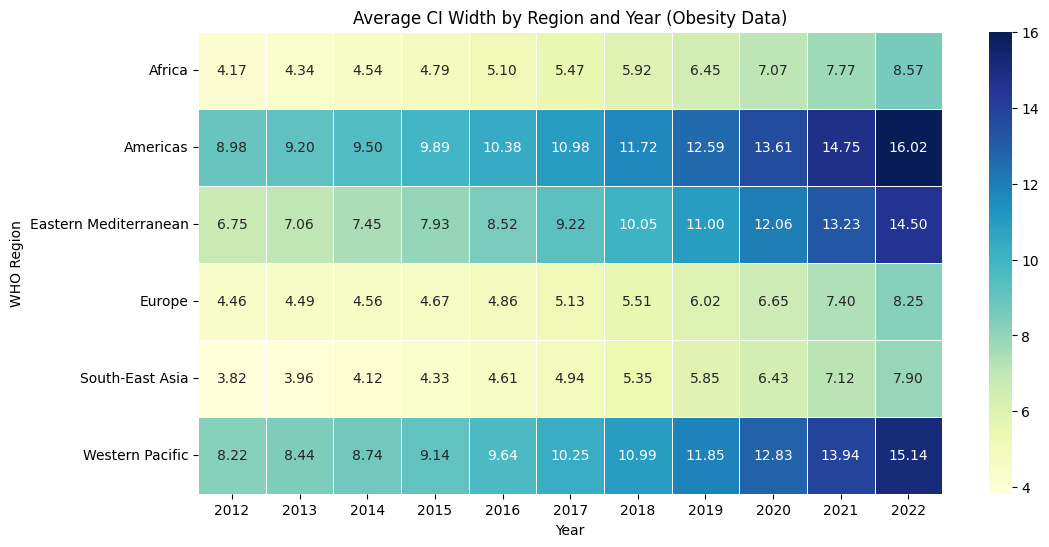

In [ ]:
#Pivot the data: Region as rows, Year as columns
heatmap_data= df_obesity.pivot_table(values='CI_Width', index='Region', columns='Year', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Average CI Width by Region and Year (Obesity Data)")
plt.ylabel("WHO Region")
plt.xlabel("Year")
plt.show()

**H: Scatter Plot: Obesity vs Malnutrition (Merged by Country-Year)**

*(shows countries where obesity & malnutrition coexist)*

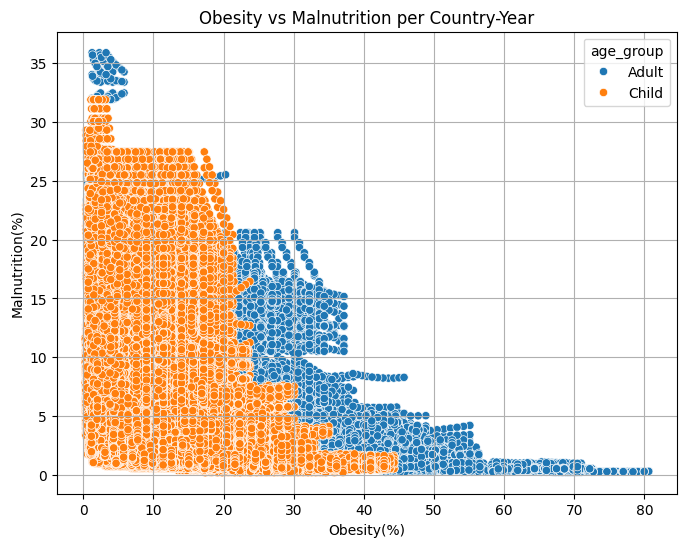

In [ ]:
#Merge datasets based on Country,year,gender and age group
merge_cols= ['Country', 'Year', 'Gender', 'age_group']

merged= pd.merge(
    df_obesity[merge_cols + ['Mean_Estimate']],
    df_malnutrition[merge_cols + ['Mean_Estimate']],
    on=merge_cols,
    suffixes=('_Obesity', '_Malnutrition'))
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged, x='Mean_Estimate_Obesity', y='Mean_Estimate_Malnutrition', hue='age_group')
plt.title("Obesity vs Malnutrition per Country-Year")
plt.xlabel("Obesity(%)")
plt.ylabel("Malnutrition(%)")
plt.grid()
plt.show()

**I: Countries with Extreme CI_Width**

*(Outliers in reliability)*

In [ ]:
#Group by Country, average CI Width
ci_summary=df_obesity.groupby('Country')['CI_Width'].mean().reset_index()
#Top 10 highest CI width
high_ci= ci_summary.sort_values('CI_Width', ascending=False).head(10)
print("Top 10 Countries with Highest Average CI Width (Obesity):")
print(high_ci)
#Top 10 lowest CI width
low_ci= ci_summary.sort_values('CI_Width').head(10)
print("\nTop 10 Countries with Lowest Average CI Width (Obesity):")
print(low_ci)

Top 10 Countries with Highest Average CI Width (Obesity):
                  Country   CI_Width
20                Bermuda  24.593417
3          American Samoa  23.113530
6     Antigua and Barbuda  22.016214
145           Puerto Rico  21.698679
72                Grenada  21.458487
170              Suriname  20.596436
179               Tokelau  20.451204
173  Syrian Arab Republic  20.157261
4                 Andorra  18.210110
153                 Samoa  18.115278

Top 10 Countries with Lowest Average CI Width (Obesity):
                Country  CI_Width
81                India  1.140133
89                Japan  1.155903
177         Timor-Leste  1.273569
28         Burkina Faso  1.531514
60             Ethiopia  1.589414
14           Bangladesh  1.663506
95   Korea, Republic of  2.016314
149              Rwanda  2.360579
142         Philippines  2.399143
37                China  2.399269


/tmp/ipython-input-29-510429020.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=high_ci, x='CI_Width', y='Country', palette='Reds_r')


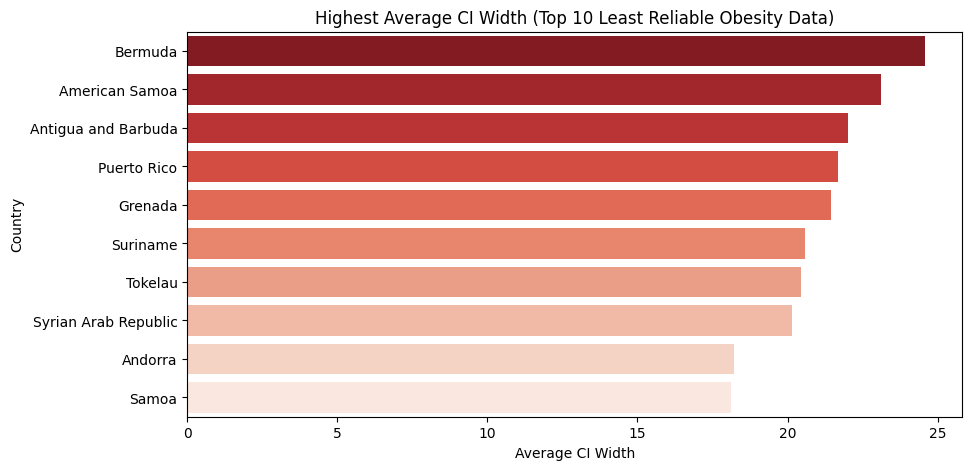

/tmp/ipython-input-29-510429020.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=low_ci, x='CI_Width', y='Country', palette='Greens')


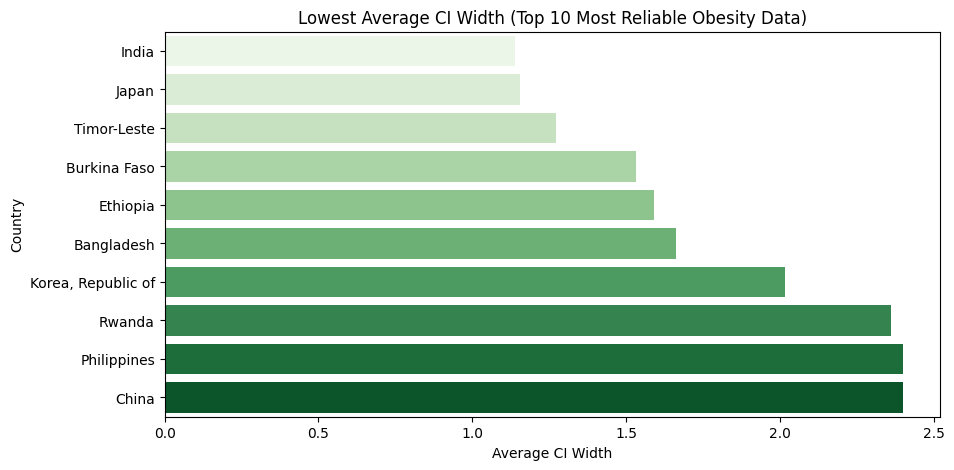

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=high_ci, x='CI_Width', y='Country', palette='Reds_r')
plt.title("Highest Average CI Width (Top 10 Least Reliable Obesity Data)")
plt.xlabel("Average CI Width")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=low_ci, x='CI_Width', y='Country', palette='Greens')
plt.title("Lowest Average CI Width (Top 10 Most Reliable Obesity Data)")
plt.xlabel("Average CI Width")
plt.show()

# **Step 4: A] SQL Insertion**

In [ ]:
import sqlite3
conn = sqlite3.connect("nutrition_paradox.db")
cursor = conn.cursor()

In [ ]:
cursor.execute("DROP TABLE IF EXISTS obesity")
cursor.execute("DROP TABLE IF EXISTS malnutrition")

#Create obesity table
cursor.execute("""
CREATE TABLE IF NOT EXISTS obesity(
    Year INTEGER,
    Gender TEXT,
    Mean_Estimate REAL,
    CI_Lower REAL,
    CI_Upper REAL,
    Age_Group TEXT,
    Country TEXT,
    Region TEXT,
    CI_Width REAL,
    Obesity_Level TEXT
)
""")
#Create malnutrition table
cursor.execute("""
CREATE TABLE IF NOT EXISTS malnutrition(
    Year INTEGER,
    Gender TEXT,
    Mean_Estimate REAL,
    CI_Lower REAL,
    CI_Upper REAL,
    Age_Group TEXT,
    Country TEXT,
    Region TEXT,
    CI_Width REAL,
    Malnutrition_Level TEXT
)
""")
conn.commit()

In [ ]:
for index, row in df_obesity.iterrows():
    cursor.execute("""
        INSERT INTO obesity(
            Year, Gender, Mean_Estimate, CI_Lower, CI_Upper,
            Age_Group, Country, Region, CI_Width, Obesity_Level
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        row['Year'], row['Gender'], row['Mean_Estimate'], row['LowerBound'], row['UpperBound'],
        row['age_group'], row['Country'], row['Region'], row['CI_Width'],
        row.get('Obesity_Level')
    ))
conn.commit()

In [ ]:
for index, row in df_malnutrition.iterrows():
    cursor.execute("""
        INSERT INTO malnutrition (
            Year, Gender, Mean_Estimate, CI_Lower, CI_Upper,
            Age_Group, Country, Region, CI_Width, Malnutrition_Level
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        row['Year'], row['Gender'], row['Mean_Estimate'], row['LowerBound'], row['UpperBound'],
        row['age_group'], row['Country'], row['Region'], row['CI_Width'],
        row.get('Malnutrition_Level')
    ))
conn.commit()

# **B] Obesity Table (10 Queries)**

**1. Top 5 regions with the highest average obesity levels in the most recent year (2022)**

In [ ]:
import pandas as pd
query1="""
SELECT Region, ROUND(AVG(Mean_Estimate), 2) AS Avg_Obesity
FROM obesity
WHERE Year = 2022
GROUP BY Region
ORDER BY Avg_Obesity DESC
LIMIT 5;
"""

df = pd.read_sql_query(query1, conn)
df.head()

,Region,Avg_Obesity
0,Western Pacific,23.01
1,Americas,21.21
2,Eastern Mediterranean,18.13
3,Europe,12.99
4,None,11.46


**2. Top 5 countries with highest obesity estimates**

In [ ]:
query2= """
SELECT Country, ROUND(AVG(Mean_Estimate), 2) AS Avg_Obesity
FROM obesity
GROUP BY Country
ORDER BY Avg_Obesity DESC
LIMIT 5;
"""

df = pd.read_sql_query(query2, conn)
df.head()

,Country,Avg_Obesity
0,Niue,40.66
1,Cook Islands,39.92
2,Nauru,38.51
3,Tokelau,37.96
4,American Samoa,36.89


**3. Obesity trend in India over the years (Mean_Estimate)**

In [ ]:
query3="""
SELECT Year, ROUND(AVG(Mean_Estimate), 2) AS India_Obesity
FROM obesity
WHERE Country='India'
GROUP BY Year
ORDER BY Year;
"""
df = pd.read_sql_query(query3, conn)
df

,Year,India_Obesity
0,2012,2.47
1,2013,2.63
2,2014,2.80
3,2015,2.97
4,2016,3.16
5,2017,3.36
6,2018,3.58
7,2019,3.81
8,2020,4.05
9,2021,4.31


**4. Average obesity by gender**

In [ ]:
query4="""
SELECT Gender, ROUND(AVG(Mean_Estimate), 2) AS Avg_Obesity
FROM obesity
GROUP BY Gender;
"""
df = pd.read_sql_query(query4, conn)
df

,Gender,Avg_Obesity
0,Both,12.76


**5. Country count by obesity level category and age group**

In [ ]:
query5= """
SELECT Obesity_Level, age_group, COUNT(DISTINCT Country) AS Country_Count
FROM obesity
GROUP BY Obesity_Level, age_group
ORDER BY Obesity_Level, age_group;
"""

df=pd.read_sql_query(query5, conn)
df

,Obesity_Level,Age_Group,Country_Count
0,High,Adult,92
1,High,Child,11
2,Low,Adult,166
3,Low,Child,199
4,Moderate,Adult,95
5,Moderate,Child,26


**6.Top 5 least reliable (highest CI_Width) and most consistent (lowest CI_Width) countries**

In [ ]:
query6="""
SELECT Country, ROUND(AVG(CI_Width), 2) AS Avg_CI_Width
FROM obesity
GROUP BY Country
ORDER BY Avg_CI_Width DESC;
"""
#Unreliable
df1=pd.read_sql_query(query6, conn).head(5)
df1

,Country,Avg_CI_Width
0,Bermuda,24.59
1,American Samoa,23.11
2,Antigua and Barbuda,22.02
3,Puerto Rico,21.70
4,Grenada,21.46


In [ ]:
#Consistent
df2=pd.read_sql_query(query6, conn).tail(5)
df2

,Country,Avg_CI_Width
195,Burkina Faso,1.53
196,None,1.47
197,Timor-Leste,1.27
198,Japan,1.16
199,India,1.14


**7. Average obesity by age group**

In [ ]:
query7="""
SELECT Age_Group, ROUND(AVG(Mean_Estimate), 2) AS Avg_Obesity
FROM obesity
GROUP BY Age_Group
ORDER BY Avg_Obesity DESC;
"""
pd.read_sql_query(query7, conn)

,Age_Group,Avg_Obesity
0,Adult,21.83
1,Child,9.74


**8. Top 10 countries with consistent low obesity (low average + low CI)**

In [ ]:
query8="""
SELECT Country, ROUND(AVG(Mean_Estimate),2) AS Avg_Obesity, ROUND(AVG(CI_Width),2) AS Avg_CI
FROM obesity
GROUP BY Country
HAVING Avg_Obesity<25 AND Avg_CI<2
ORDER BY Avg_Obesity ASC, Avg_CI ASC;
"""
df8=pd.read_sql_query(query8, conn)
df8

,Country,Avg_Obesity,Avg_CI
0,Timor-Leste,0.99,1.27
1,Ethiopia,1.49,1.59
2,Burkina Faso,1.72,1.53
3,Bangladesh,1.98,1.66
4,India,3.43,1.14
5,Japan,4.00,1.16
6,None,9.74,1.47


In [ ]:
query9="""
WITH GenderStats AS(SELECT Country, Year, Gender, AVG(Mean_Estimate) AS Avg_Obesity
  FROM obesity
  GROUP BY Country, Year, Gender)
SELECT f.Country, f.Year,
       ROUND(f.Avg_Obesity-m.Avg_Obesity, 2) AS Obesity_Gap
FROM GenderStats f
JOIN GenderStats m ON f.Country=m.Country AND f.Year=m.Year
WHERE f.Gender = 'Female' AND m.Gender = 'Male'
  AND Obesity_Gap>5
ORDER BY Obesity_Gap DESC;
"""
pd.read_sql_query(query9, conn)

,Country,Year,Obesity_Gap


**10. Global average obesity percentage per year**

In [ ]:
query10="""
SELECT Year, ROUND(AVG(Mean_Estimate), 2) AS Global_Avg_Obesity
FROM obesity
GROUP BY Year
ORDER BY Year;
"""
pd.read_sql_query(query10, conn)

,Year,Global_Avg_Obesity
0,2012,11.06
1,2013,11.36
2,2014,11.67
3,2015,11.99
4,2016,12.33
5,2017,12.69
6,2018,13.06
7,2019,13.44
8,2020,13.84
9,2021,14.25


# **C] 10 Malnutrition Queries**
**1. Avg. malnutrition by age group**

In [ ]:
queryM1="""
SELECT age_group, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
GROUP BY age_group
ORDER BY Avg_Malnutrition DESC;
"""
df1=pd.read_sql_query(queryM1, conn)
df1

,Age_Group,Avg_Malnutrition
0,Adult,5.94
1,Child,5.16


**2. Top 5 countries with highest malnutrition (mean_estimate)**

In [ ]:
query2="""
SELECT Country, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
GROUP BY Country
ORDER BY Avg_Malnutrition DESC
LIMIT 5;
"""

df2=pd.read_sql_query(query2, conn)
df2

,Country,Avg_Malnutrition
0,India,22.14
1,Bangladesh,18.25
2,Sri Lanka,17.87
3,Eritrea,17.47
4,Ethiopia,17.39


**3. Malnutrition trend in African region over the years**

In [ ]:
query3="""
SELECT Year, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
WHERE Region='Africa'
GROUP BY Year
ORDER BY Year;
"""
df3=pd.read_sql_query(query3, conn)
df3

,Year,Avg_Malnutrition
0,2012,8.85
1,2013,8.75
2,2014,8.66
3,2015,8.59
4,2016,8.52
5,2017,8.47
6,2018,8.41
7,2019,8.37
8,2020,8.33
9,2021,8.30


**4. Gender-based average malnutrition**

In [ ]:
query4="""
SELECT Gender, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
GROUP BY Gender
ORDER BY Avg_Malnutrition DESC;
"""
df4=pd.read_sql_query(query4, conn)
df4

,Gender,Avg_Malnutrition
0,Both,5.35


**5. Malnutrition level-wise average CI_Width by age group**

In [ ]:
query5="""
SELECT Malnutrition_Level, age_group, ROUND(AVG(CI_Width), 2) AS Avg_CI_Width
FROM malnutrition
GROUP BY Malnutrition_Level, age_group
ORDER BY Avg_CI_Width DESC;
"""
df5=pd.read_sql_query(query5, conn)
df5

,Malnutrition_Level,Age_Group,Avg_CI_Width
0,Moderate,Child,9.89
1,High,Adult,9.25
2,High,Child,7.88
3,Moderate,Adult,7.64
4,Low,Child,4.44
5,Low,Adult,2.64


**6. Yearly malnutrition change in India, Nigeria, Brazil**

In [ ]:
query6= """
SELECT Country, Year, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
WHERE Country IN ('India', 'Nigeria', 'Brazil')
GROUP BY Country, Year
ORDER BY Country, Year;
"""
df6= pd.read_sql_query(query6, conn)
df6

,Country,Year,Avg_Malnutrition
0,Brazil,2012,2.84
1,Brazil,2013,2.78
2,Brazil,2014,2.74
3,Brazil,2015,2.70
4,Brazil,2016,2.67
5,Brazil,2017,2.65
6,Brazil,2018,2.64
7,Brazil,2019,2.63
8,Brazil,2020,2.63
9,Brazil,2021,2.63


**7. Regions with lowest malnutrition averages**

In [ ]:
query7="""
SELECT Region, ROUND(AVG(Mean_Estimate), 2) AS Avg_Malnutrition
FROM malnutrition
GROUP BY Region
ORDER BY Avg_Malnutrition ASC
LIMIT 5;
"""
df7=pd.read_sql_query(query7, conn)
df7

,Region,Avg_Malnutrition
0,Europe,2.43
1,Americas,3.17
2,Western Pacific,3.22
3,Eastern Mediterranean,6.66
4,None,8.35


**8. Countries with increasing malnutrition (positive change over years)**

In [ ]:
query8="""
SELECT Country, MIN(Mean_Estimate) AS Min_Malnutrition, MAX(Mean_Estimate) AS Max_Malnutrition, ROUND(MAX(Mean_Estimate)-MIN(Mean_Estimate), 2) AS Change
FROM malnutrition
GROUP BY Country
HAVING Change>0
ORDER BY Change DESC;
"""
df8=pd.read_sql_query(query8, conn)
df8

,Country,Min_Malnutrition,Max_Malnutrition,Change
0,Eritrea,7.868055,35.894114,28.03
1,None,1.247402,27.459648,26.21
2,Ethiopia,7.553969,29.304048,21.75
3,Somalia,4.688896,25.521731,20.83
4,India,13.073501,31.900835,18.83
...,...,...,...,...
195,Cook Islands,0.449898,1.637155,1.19
196,Peru,0.825172,1.985275,1.16
197,Niue,0.353357,1.249841,0.90
198,American Samoa,0.246522,1.146955,0.90


**9. Min/Max malnutrition levels year-wise comparison**

In [ ]:
query9="""
SELECT Year, ROUND(MIN(Mean_Estimate), 2) AS Min_Malnutrition, ROUND(MAX(Mean_Estimate), 2) AS Max_Malnutrition
FROM malnutrition
GROUP BY Year
ORDER BY Year;
"""
df9=pd.read_sql_query(query9, conn)
df9

,Year,Min_Malnutrition,Max_Malnutrition
0,2012,0.18,35.89
1,2013,0.18,35.69
2,2014,0.18,35.50
3,2015,0.18,35.31
4,2016,0.18,35.15
5,2017,0.18,35.00
6,2018,0.18,34.86
7,2019,0.18,34.72
8,2020,0.18,34.58
9,2021,0.18,34.43


**10. High CI_Width flags for monitoring (CI_Width>5)**

In [ ]:
query10="""
SELECT Country, Year, Mean_Estimate, CI_Width
FROM malnutrition
WHERE CI_Width>5
ORDER BY CI_Width DESC;
"""
df10=pd.read_sql_query(query10, conn)
df10

,Country,Year,Mean_Estimate,CI_Width
0,Senegal,2022,16.941771,26.701744
1,Senegal,2021,16.992038,25.679344
2,Senegal,2020,17.046429,24.586366
3,Mauritania,2022,16.080868,23.810544
4,Senegal,2019,17.105949,23.466897
...,...,...,...,...
9567,Jordan,2019,3.876585,5.001890
9568,Comoros,2018,3.272964,5.001566
9569,Philippines,2021,7.551254,5.001525
9570,Sierra Leone,2021,4.989996,5.000505


# **D] Combined Queries**

**1: Obesity vs Malnutrition comparison by country (any 5 countries)**

In [ ]:
queryC1="""
SELECT o.Country,
       ROUND(AVG(o.Mean_Estimate), 2) AS Avg_Obesity,
       ROUND(AVG(m.Mean_Estimate), 2) AS Avg_Malnutrition
FROM obesity o
JOIN malnutrition m ON o.Country = m.Country
WHERE o.Country IN ('India', 'Senegal', 'Brazil', 'Nigeria', 'Japan')
  AND m.Country IN ('India', 'Senegal', 'Brazil', 'Nigeria', 'Japan')
GROUP BY o.Country;
"""
df11=pd.read_sql_query(queryC1, conn)
df11

,Country,Avg_Obesity,Avg_Malnutrition
0,Brazil,16.61,2.69
1,India,3.43,22.14
2,Japan,4.00,3.84
3,Nigeria,4.47,11.89
4,Senegal,3.23,16.82


**2. Gender-based disparity in both obesity and malnutrition**

In [ ]:
query2="""
SELECT o.Gender,
       ROUND(AVG(o.Mean_Estimate), 2) AS Avg_Obesity,
       ROUND(AVG(m.Mean_Estimate), 2) AS Avg_Malnutrition
FROM obesity o
JOIN malnutrition m ON o.Gender=m.Gender
GROUP BY o.Gender;
"""
df12=pd.read_sql_query(query2, conn)
df12

**3. Region-wise average estimates side-by-side (Africa and America)**

In [ ]:
query3="""
SELECT o.Region,
       ROUND(AVG(o.Mean_Estimate), 2) AS Avg_Obesity,
       ROUND(AVG(m.Mean_Estimate), 2) AS Avg_Malnutrition
FROM obesity o
JOIN malnutrition m ON o.Region = m.Region
WHERE o.Region IN ('Africa', 'Americas') AND m.Region IN ('Africa', 'Americas')
GROUP BY o.Region;
"""
df13= pd.read_sql_query(query3, conn)
df13

**4. Countries with obesity increasing & malnutrition decreasing**

In [ ]:
query14="""
WITH obesity_change AS(
    SELECT Country,
           MIN(Year) AS Start_Year,
           MAX(Year) AS End_Year,
           MIN(Mean_Estimate) AS Min_Obesity,
           MAX(Mean_Estimate) AS Max_Obesity
    FROM obesity
    GROUP BY Country),
malnutrition_change AS(
    SELECT Country,
           MIN(Year) AS Start_Year,
           MAX(Year) AS End_Year,
           MIN(Mean_Estimate) AS Min_Malnutrition,
           MAX(Mean_Estimate) AS Max_Malnutrition
    FROM malnutrition
    GROUP BY Country)
SELECT o.Country,
       ROUND(o.Min_Obesity, 2) AS Start_Obesity,
       ROUND(o.Max_Obesity, 2) AS End_Obesity,
       ROUND(m.Min_Malnutrition, 2) AS Start_Malnutrition,
       ROUND(m.Max_Malnutrition, 2) AS End_Malnutrition
FROM obesity_change o
JOIN malnutrition_change m ON o.Country = m.Country
WHERE o.Max_Obesity>o.Min_Obesity AND m.Max_Malnutrition<m.Min_Malnutrition
LIMIT 10;
"""
df14=pd.read_sql_query(query14, conn)
df14

**5. Age-wise trend analysis**

In [57]:
query15="""
SELECT o.age_group,
       ROUND(AVG(o.Mean_Estimate), 2) AS Avg_Obesity,
       ROUND(AVG(m.Mean_Estimate), 2) AS Avg_Malnutrition
FROM obesity o
JOIN malnutrition m ON o.age_group=m.age_group
GROUP BY o.age_group
ORDER BY o.age_group;
"""
df15=pd.read_sql_query(query15, conn)
df15

,Age_Group,Avg_Obesity,Avg_Malnutrition
0,Adult,21.83,5.94
1,Child,9.74,5.16
